In [1]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [2]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [3]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

100%|██████████| 16/16 [00:01<00:00, 13.84it/s]


In [4]:
def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)
    

# from queue import SimpleQueue as squeue
def EDESpairs(diastole, systole):
    dframes = np.sort(np.array(diastole))
    sframes = np.sort(np.array(systole))
    clips = []
    
    inds = np.searchsorted(dframes, sframes, side='left')
    for i, sf in enumerate(sframes):
        if inds[i] == 0: # no prior diastolic frames for this sf
            continue
        best_df = diastole[inds[i]-1] # diastole frame nearest this sf.
        if len(clips) == 0 or best_df != clips[-1][0]:
            clips.append((best_df, sf))
            
    return clips

In [5]:
model_save_path = "save_models/R2plus1DMotionSegNet_model_tmp.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


### 1. Function for computing EF using fused segmentations

In [6]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def segment_a_video_with_fusion(video, interpolate_last=True, step=1, num_clips=10, 
                                fuse_method="simple", class_list=[0, 1]):
    if video.shape[1] < 32 + num_clips * step:
        num_clips = (video.shape[1] - 32) // step
    if num_clips < 0:
        print("Video is too short")
        num_clips = 1
    all_consecutive_clips = []

    for shift_dis in range(0, num_clips * step, step):
        shifted_video = video[:, shift_dis:]
        consecutive_clips = divide_to_consecutive_clips(shifted_video, interpolate_last=interpolate_last)
        all_consecutive_clips.append(consecutive_clips)

    all_consecutive_clips = np.array(all_consecutive_clips)
    all_segmentations = []

    for i in range(len(all_consecutive_clips)):
        consecutive_clips = all_consecutive_clips[i]
        segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))

        for i in range(consecutive_clips.shape[0]):
            one_clip = np.expand_dims(consecutive_clips[i], 0)
            segmentation_output, motion_output = model(torch.Tensor(one_clip))
            segmentation_output = F.softmax(segmentation_output, 1)
            segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        segmentation_outputs = segmentation_outputs[1:]

        all_segmentations.append(segmentation_outputs)

    for i in range(len(all_segmentations)):
        all_segmentations[i] = all_segmentations[i].transpose([1, 0, 2, 3, 4])
        all_segmentations[i] = all_segmentations[i].reshape(2, -1, 112, 112)

    all_interpolated_segmentations = []
    for i in range(0, len(all_consecutive_clips)):
        video_clip = video[:, i * step:]
        if interpolate_last and (video_clip.shape[1] % 32 != 0):
            interpolated_segmentations = torch.Tensor(all_segmentations[i]).unsqueeze(0)
            interpolated_segmentations = F.interpolate(interpolated_segmentations, size=(video_clip.shape[1], 112, 112), 
                                                       mode="trilinear", align_corners=False)
            interpolated_segmentations = interpolated_segmentations.squeeze(0).numpy()
            all_interpolated_segmentations.append(np.argmax(interpolated_segmentations, 0))
        else:
            all_interpolated_segmentations.append(np.argmax(all_segmentations[i], 0))

    fused_segmentations = [all_interpolated_segmentations[0][0]]

    for i in range(1, video.shape[1]):
        if step - 1 < i:
            images_to_fuse = []
            for index in range(min(i, len(all_interpolated_segmentations))):
                if i - index * step < 0:
                    break
                images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[index][i - index * step].astype("uint8"),
                                                            isVector=False))
            if len(images_to_fuse) <= 1:
                fused_segmentations.append(itk.GetArrayFromImage(images_to_fuse[0]))
            else:
                fused_image = fuse_images(images_to_fuse, fuse_method, class_list=class_list)
                # If using SIMPLE, the fused image might be in type "float"
                # So convert it to uint
                fused_segmentations.append(itk.GetArrayFromImage(fused_image).astype("uint8"))

    fused_segmentations = np.array(fused_segmentations)
    
    return fused_segmentations


def compute_ef_using_putative_clips(fused_segmentations, test_pat_index):
    size = np.sum(fused_segmentations, axis=(1, 2)).ravel()
    _05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

    trim_min = _05cut
    trim_max = _95cut
    trim_range = trim_max - trim_min
    systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
    diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

    # keep only real diastoles..
    diastole = [x for x in diastole if size[x] >= _85cut]
    # Add first frame
    if np.mean(size[:3]) >= _85cut:
        diastole = [0] + diastole
    diastole = np.array(diastole)

    clip_pairs = EDESpairs(diastole, systole)

    one_array_of_segmentations = fused_segmentations.reshape(-1, 112, 112)

    predicted_efs = []

    for i in range(len(clip_pairs)):
        output_ED = one_array_of_segmentations[clip_pairs[i][0]]
        output_ES = one_array_of_segmentations[clip_pairs[i][1]]
        
        length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
        length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

        edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
        esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

        ef_predicted = (edv - esv) / edv * 100
        
        if ef_predicted < 0:
            print("Negative EF at patient:{:04d}".format(test_pat_index))
            continue

        predicted_efs.append(ef_predicted)

    return predicted_efs


def compute_ef_using_reported_clip(segmentations, ed_index, es_index):
    output_ED = segmentations[ed_index]
    output_ES = segmentations[es_index]

    lv_ed_dice = categorical_dice((output_ED), ed_label, 1)
    lv_es_dice = categorical_dice((output_ES), es_label, 1)

    length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
    length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))
    
    edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
    esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

    ef_predicted = (edv - esv) / edv * 100
    
    return ef_predicted, lv_ed_dice, lv_es_dice

### 2. Compute the Ejection Fraction for all Test Patients

In [7]:
patient_filename = []

EF_list = []
true_EF_list = []
mean_EF_list = []

lv_ed_dice = []
lv_es_dice = []

num_clips = 5
step = 1
interpolate_last = True
fuse_method = "simple"
class_list = [0, 1]
# class_list = None

start = time.time()

for i in range(len(test_dataset)):
    test_pat_index = i
    try:
        video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]
    except:
        print("Get exception when trying to read the video from patient:{:04d}".format(i))
        continue

    if test_pat_index == 1053:
        video = video[:, :80]
    
    segmentations = segment_a_video_with_fusion(video, interpolate_last=interpolate_last, 
                                                step=step, num_clips=num_clips,
                                                fuse_method=fuse_method, class_list=class_list)

    predicted_efs = compute_ef_using_putative_clips(segmentations, test_pat_index=test_pat_index)
    
    _, ed_dice, es_dice = compute_ef_using_reported_clip(segmentations, ed_index, es_index)

    lv_ed_dice.append(ed_dice)
    lv_es_dice.append(es_dice)
    
    if len(predicted_efs) == 0:
        print("Cannot identify clips at patient:{:04d}".format(test_pat_index))
        continue
    
    if np.isnan(np.nanmean(predicted_efs)):
        print("Cannot identify clips at patient:{:04d}".format(test_pat_index))
        continue
               
    EF_list.append(predicted_efs)
    true_EF_list.append(EF)
    mean_EF_list.append(np.nanmean(predicted_efs))
    patient_filename.append(filename[:-4])
    
end = time.time()

print("Used time = {:.0f} mins {:.0f} secs".format((end - start) // 60, (end - start) % 60))

/opt/anaconda3/envs/dynamic37-labelfusion/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Cannot identify clips at patient:0095
Cannot identify clips at patient:0294
Cannot identify clips at patient:0390
Cannot identify clips at patient:0573
Cannot identify clips at patient:0612
Cannot identify clips at patient:1061
Cannot identify clips at patient:1215
Used time = 68 mins 46 secs


### Label fusion of 5 clips with step 1 using full video segmentation

In [8]:
errors = np.array(np.array(true_EF_list) - np.array(mean_EF_list))
abs_errors = abs(errors)

print("Mean absolute error (standard deviation):  {:.4f} ({:.4f}) %".format(np.mean(abs_errors), np.std(abs_errors)))
print("Median absolute error:  {:.4f} %".format(np.median(abs_errors)))
print("Bias +- 1.96 x std:  {:.4f} +- {:.4f}".format(np.mean(errors), 1.96 * np.std(errors)))
print("Percentile of mae 50%: {:6.4f}  75%: {:6.4f}  95%: {:6.4f}".format(np.percentile(abs_errors, 50), np.percentile(abs_errors, 75),
                                                                    np.percentile(abs_errors, 95)))

Mean absolute error (standard deviation):  5.2519 (4.4517) %
Median absolute error:  4.1038 %
Bias +- 1.96 x std:  -2.0939 +- 12.8549
Percentile of mae 50%: 4.1038  75%: 7.3610  95%: 13.8551


In [9]:
print("Average ED {:.4f} ({:.4f})".format(np.mean(lv_ed_dice), np.std(lv_ed_dice)))
print("Median ED {:.4f}".format(np.median(lv_ed_dice)))
print("Average ES {:.4f} ({:.4f})".format(np.mean(lv_es_dice), np.std(lv_es_dice)))
print("Median ES {:.4f}".format(np.median(lv_es_dice)))

Average ED 0.9354 (0.0324)
Median ED 0.9421
Average ES 0.9073 (0.0515)
Median ES 0.9189


### BA Plot with Brackets

In [28]:
from scipy.stats import linregress

def bland_altman_plot_TwoPop(data1, data2, baseline_BA_limit=None, linewidth=2.5, *args, **kwargs):
    
    if 'c' in kwargs:
        # Pandas, amazing!
        colorSeries = pd.Series([tuple(row) for row in kwargs['c']])
        colorCounts = colorSeries.value_counts()
        # returns the color counts in descending order.
        pop1c, pop2c = colorCounts.index[0], colorCounts.index[1]
        print('TwoPop: found colors {}({}) and {}({})'.\
             format(pop1c, colorCounts[0], pop2c, colorCounts[1]))

        pop1i = colorSeries[colorSeries == pop1c].index.values
        pop2i = colorSeries[colorSeries == pop2c].index.values
        
    
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    print('Dims data1 {}, diff {}'.format(data1.shape, diff.shape))
    
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md, linestyle='-')
    
    axes = plt.gca()
    x_lim = axes.get_xlim()
    x_range = x_lim[1] - x_lim[0]
    
    plt.annotate("", xy=(x_lim[0] + 0.20 * x_range, md + np.percentile(abs(diff), 50)), xytext=(x_lim[0] + 0.20 * x_range, md - np.percentile(abs(diff), 50)),
                 arrowprops=dict(arrowstyle='|-|', color='darkorange', linestyle='-', mutation_scale =3.2, linewidth=linewidth))
    plt.annotate("", xy=(x_lim[1] - 0.20 * x_range, md + np.percentile(abs(diff), 50)), xytext=(x_lim[1] - 0.20 * x_range, md - np.percentile(abs(diff), 50)),
                 arrowprops=dict(arrowstyle='|-|', color='darkorange', linestyle='-', mutation_scale =3.2, linewidth=linewidth))
    
    plt.annotate("", xy=(x_lim[0] + 0.15 * x_range, md + np.percentile(abs(diff), 75)), xytext=(x_lim[0] + 0.15 * x_range, md - np.percentile(abs(diff), 75)),
                 arrowprops=dict(arrowstyle='|-|', color='red', linestyle='-', mutation_scale =4.2, linewidth=linewidth))
    plt.annotate("", xy=(x_lim[1] - 0.15 * x_range, md + np.percentile(abs(diff), 75)), xytext=(x_lim[1] - 0.15 * x_range, md - np.percentile(abs(diff), 75)),
                 arrowprops=dict(arrowstyle='|-|', color='red', linestyle='-', mutation_scale =4.2, linewidth=linewidth))
    
    plt.annotate("", xy=(x_lim[0] + 0.10 * x_range, md + 1.96 * sd), xytext=(x_lim[0] + 0.10 * x_range, md - 1.96 * sd),
                 arrowprops=dict(arrowstyle='|-|', color='blue', linestyle='-', mutation_scale =5.2, linewidth=linewidth))
    plt.annotate("", xy=(x_lim[1] - 0.10 * x_range, md + 1.96 * sd), xytext=(x_lim[1] - 0.10 * x_range, md - 1.96 * sd),
                 arrowprops=dict(arrowstyle='|-|', color='blue', linestyle='-', mutation_scale =5.2, linewidth=linewidth))
    axes.tick_params(labelsize=21)
    
    plt.text(x_lim[1] - 0.4, md  + 1, '{:.1f}'.format(md), horizontalalignment='right')
    plt.text(max(mean) + 1, md + 1.96*sd +1, '{:.1f}'.format(md + 1.96*sd), horizontalalignment='right')
    
    plt.ylim(top=max(diff) + 15)
    
    if baseline_BA_limit != None:
        plt.axhline(md + baseline_BA_limit, color='black', linestyle='dotted', alpha=1.0)
        plt.axhline(md - baseline_BA_limit, color='black', linestyle='dotted', alpha=1.0)
        
    
    plt.text(max(mean) + 1, md - 1.96*sd - 6, '{:.1f}'.format(md - 1.96*sd), horizontalalignment='right')
    
    arrow_50 = mlines.Line2D([], [], color='darkorange', linestyle='-', label='50 % ({:.1f})'.format(np.percentile(abs(diff), 50)))
    arrow_75 = mlines.Line2D([], [], color='red', linestyle='-', label='75 % ({:.1f})'.format(np.percentile(abs(diff), 75)))
    arrow_std = mlines.Line2D([], [], color='blue', linestyle='-', label=r'1.96 $\sigma$ ({:.1f})'.format(1.96 * sd))
    
    plt.legend(handles=[arrow_50, arrow_75, arrow_std], loc='upper left', prop={'size': 18}, frameon=False)

    print('Bias {:.4f}, med bias {:.4f}, BA limits +- {:.4f} ({:.4f})'.format(md, np.median(diff), 1.96*sd, sd))
    print('50, 75, 95 abs error percentile:\n {:.4f}  {:.4f}  {:.4f}'.format(np.percentile(abs(diff), 50), np.percentile(abs(diff), 75),
                                                                             np.percentile(abs(diff), 95)))

    if 'c' in kwargs:
        # Now get the md and sd for the two populations.
        md1 = np.mean(diff[pop1i])
        sd1 = np.std(diff[pop1i])
        md2 = np.mean(diff[pop2i])
        sd2 = np.std(diff[pop2i])
        # And plot
        for md, sd, c in [(md1, sd1, pop1c), (md2, sd2, pop2c)]:
            plt.axhline(md,           color=c, linestyle='--')
            plt.axhline(md + np.percentile(abs(diff), 50), color='orange', linestyle='dashed', label='50 percentile')
            plt.axhline(md - np.percentile(abs(diff), 50), color='orange', linestyle='dashed')
            plt.axhline(md + np.percentile(abs(diff), 75), color='red', linestyle='dashed', label='75 percentile')
            plt.axhline(md - np.percentile(abs(diff), 75), color='red', linestyle='dashed')
            plt.axhline(md + 1.96 * sd, color='blue', linestyle='dotted', label='Mean +- 1.96 x std')
            plt.axhline(md - 1.96 * sd, color='blue', linestyle='dotted')


def vis_linear_and_BA_plots(dataclinical, dataauto, strtitle, figsize=None,
                            linewidth=2.5,
                            datalabels = ['Clinical', 'Auto'], 
                            scatterarg={}, 
                            base_filename = None,
                            baseline_BA_limit=None):

    x = np.asarray([dataclinical, dataauto]).transpose()

    dnum = len(x[:,0])
    print('# of data : ', len(x[:,0]))
    lr = linregress(x[:,0],x[:,1])

    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(7, 7))
    #plt.subplot(211)
    plt.scatter(x[:,0], x[:,1], **scatterarg)
    plt.text(dataclinical.min(), dataauto.max() - 10, '{:d} patients\nr = {:.2f} '.format(dnum, lr[2]), fontsize=23, c='darkblue')
    plt.plot(x[:,0], lr[0] * x[:,0] + lr[1], color='red')
    plt.xlabel(datalabels[0])
    plt.ylabel(datalabels[1])
    #plt.title('{:8d} patients\nr = {:.3f} '.format(dnum, lr[2]))
    plt.axis('equal')
    plt.axis('square')
    
    if base_filename:
        # User's responsibility to set the style before getting here.
        # Save the plot, use the provided filename.
        plt.savefig(base_filename+'_LN.pdf', bbox_inches='tight')
        
        plt.savefig(base_filename+'_LN.png', bbox_inches='tight', facecolor=(1.0, 1.0, 1.0, 1.0),
                    dpi=200, transparent=False);

        plt.savefig(base_filename+'_LN_transp.png', bbox_inches='tight',
                    dpi=200, transparent=True);
    plt.show()

    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(8, 6))
    
    bland_altman_plot_TwoPop(x[:,0], x[:,1], linewidth=linewidth, baseline_BA_limit=baseline_BA_limit, **scatterarg)
    plt.title(strtitle, fontsize=22) # +' - Bland-Altman Plot (#{})'.format(dnum))

    plt.ylabel(datalabels[0] + ' - ' + datalabels[1])
    plt.xlabel('Mean of ('+datalabels[0] + ', ' + datalabels[1] + ')')
    
    if base_filename:
        # User's responsibility to set the style before getting here.
        # Save the plot, use the provided filename.
        plt.savefig(base_filename+'_BA.pdf', bbox_inches='tight')
        
        plt.savefig(base_filename+'_BA.png', bbox_inches='tight', facecolor=(1.0, 1.0, 1.0, 1.0),
                    dpi=200, transparent=False);

        plt.savefig(base_filename+'_BA_transp.png', bbox_inches='tight',
                    dpi=200, transparent=True);
    plt.show()

### BA Plot with no Variable Shading

# of data :  1269


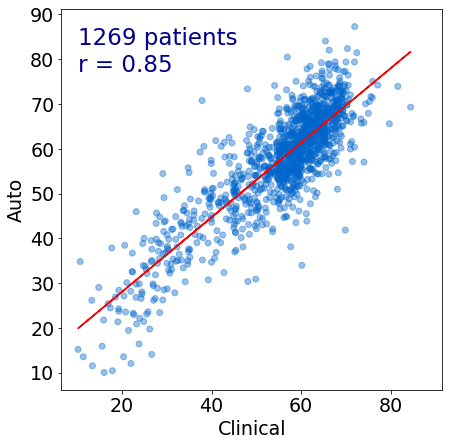

Dims data1 (1269,), diff (1269,)
Bias -2.0939, med bias -1.9336, BA limits +- 12.8549 (6.5586)
50, 75, 95 abs error percentile:
 4.1038  7.3610  13.8551


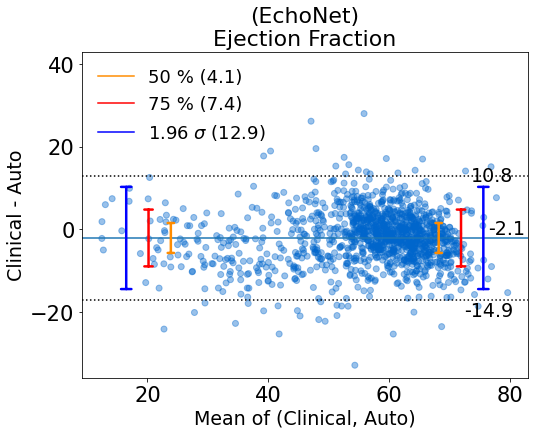

<Figure size 432x288 with 0 Axes>

In [13]:
from matplotlib.patches import mlines

import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 19}

matplotlib.rc('font', **font)

args = {"alpha": 0.4}
vis_linear_and_BA_plots(np.array(true_EF_list), np.array(mean_EF_list), 
                        strtitle="(EchoNet)\nEjection Fraction",
                        scatterarg=args, baseline_BA_limit=15.1)

plt.tight_layout()
plt.show()